raw文件读入

In [2]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.ndimage import convolve


    
df_k = []
df_theta = []

for i in range(1,6):
    df_k.append(pd.read_csv(f'./raw_data/kz_{i}.csv', header=None))
    df_theta.append(pd.read_csv(f'./raw_data/Theta_{i}.csv', header=None ))
    


import re


for i in range(5):
    print(f'kz_{i+1}.csv shape: {df_k[i].shape}')
    print(f'Theta_{i+1}.csv shape: {df_theta[i].shape}')
    
    for j in range(df_k[i].shape[1]):
        k_j = df_k[i].iloc[0 ,j]
        k_j_str = str(k_j)
        pattern = r"-0\.\d+"
        matches = re.findall(pattern,k_j_str)
        df_k[i].loc[0, j] = float(matches[0])
        
    df_k[i] = pd.DataFrame(np.array(df_k[i]).astype(float))
      
        
num_rows = 805
num_cols = 2001  
        
    
# 未解缠的 n_i
n_i = 1



/var/folders/5n/wnngr1j51d91yrx_z36vh6jr0000gn/T/ipykernel_34664/2037963179.py:16: DtypeWarning: Columns (257,317) have mixed types. Specify dtype option on import or set low_memory=False.
  df_k.append(pd.read_csv(f'./raw_data/kz_{i}.csv', header=None))
/var/folders/5n/wnngr1j51d91yrx_z36vh6jr0000gn/T/ipykernel_34664/2037963179.py:16: DtypeWarning: Columns (668,890,1035,1050,1089,1152,1162,1170,1172,1318,1421,1859) have mixed types. Specify dtype option on import or set low_memory=False.
  df_k.append(pd.read_csv(f'./raw_data/kz_{i}.csv', header=None))
/var/folders/5n/wnngr1j51d91yrx_z36vh6jr0000gn/T/ipykernel_34664/2037963179.py:16: DtypeWarning: Columns (406,599,828,1205,1287,1288,1640) have mixed types. Specify dtype option on import or set low_memory=False.
  df_k.append(pd.read_csv(f'./raw_data/kz_{i}.csv', header=None))
/var/folders/5n/wnngr1j51d91yrx_z36vh6jr0000gn/T/ipykernel_34664/2037963179.py:16: DtypeWarning: Columns (517,781,1004,1024,1096,1130,1132,1156,1166,1179,1185,12

kz_1.csv shape: (805, 2001)
Theta_1.csv shape: (805, 2001)
kz_2.csv shape: (805, 2001)
Theta_2.csv shape: (805, 2001)
kz_3.csv shape: (805, 2001)
Theta_3.csv shape: (805, 2001)
kz_4.csv shape: (805, 2001)
Theta_4.csv shape: (805, 2001)
kz_5.csv shape: (805, 2001)
Theta_5.csv shape: (805, 2001)


重写用于打表的plot函数

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

def draw3D(H):
    N, M = H.shape
    x = np.linspace(1, M, M)
    y = np.linspace(1, N, N)
    x, y = np.meshgrid(x, y)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, H, cmap='viridis')

    ax.set_title('Estimated Height')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Height(m)')

    # Rotate view by 180 degrees
    ax.view_init(elev=10, azim=135)  # elev can be adjusted for better visualization

    plt.show()
    

def plot(*argv, titles=None):
  """
  plots a given number of phase maps
  """
  if len(argv) == 1:
    f, ax = plt.subplots(1, 1, sharey=True, figsize=(5, 5))
    if titles is not None:
      ax.set_title(titles)
    a = ax.imshow(argv[0].squeeze(), cmap='jet')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    f.colorbar(a, cax=cax)
    plt.show()
  else:
    f, axes = plt.subplots(1, len(argv), sharey=True, figsize=(10, 10))
    for i in range(len(argv)):
        if titles is not None:
          axes[i].set_title(titles[i])
        a = axes[i].imshow(argv[i].squeeze(), cmap='jet')
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        f.colorbar(a, cax=cax)
    plt.show()
    f.colorbar(a, cax=cax)

def plot_hist(*argv, titles):
  """
  plots the historgram of the input phase maps
  """
  for i in range(len(argv)):
      hist = np.histogram(argv[i].ravel(), bins=100)
      plt.plot(hist[1][1:], hist[0])
  plt.xlabel("phase values")
  plt.ylabel("frequency")
  plt.title("Histogram Analysis")
  plt.grid()
  if titles is not None:
    plt.legend(titles)
  plt.show()  


In [4]:
def raw_pic(index):
    
    # 遍历每个数据点，计算结果
    results = -1 * ( np.array(df_theta[index]) + 2 * np.pi * n_i ) / np.array(df_k[index])
            
    return results

# 原始数据打表

> 先跑一遍原始数据，将n置为0，在不还原高程的情况下看一下相位纠缠导致的结果

另外打一个关于 theta 和 k 的表，查看相位分布情况 与 K 和 raw图的关系

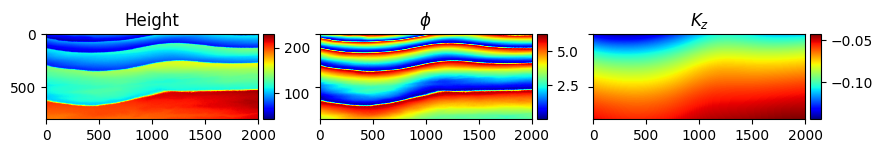

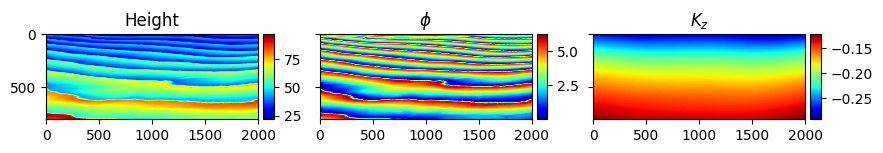

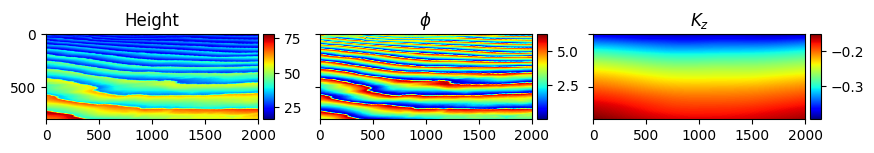

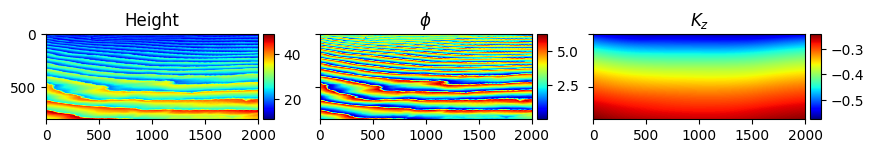

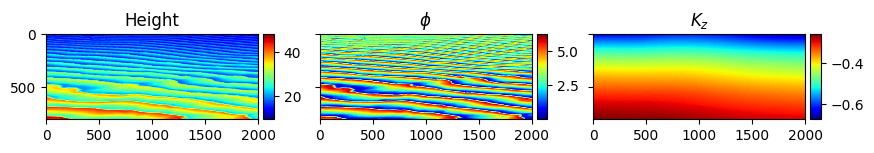

In [5]:
for i in range(5):
    plot(raw_pic(i), df_theta[i], df_k[i], titles=["Height", "$\phi$", "$K_z$"])

发现相位图与raw图在形式上是那啥的关系

基于连续性假设（相位展开）的解缠算法：

In [6]:
def unwrap_phase(theta):
    # 初始化 phi 矩阵
    phi = np.zeros_like(theta)
    phi[0, 0] = theta[0, 0]
    
    # 展开行
    for i in range(1, theta.shape[0]):
        delta = theta[i, 0] - theta[i-1, 0]
        delta_wrapped = np.mod(delta + np.pi, 2 * np.pi) - np.pi
        phi[i, 0] = phi[i-1, 0] + delta_wrapped
    
    # 展开列
    for j in range(1, theta.shape[1]):
        delta = theta[0, j] - theta[0, j-1]
        delta_wrapped = np.mod(delta + np.pi, 2 * np.pi) - np.pi
        phi[0, j] = phi[0, j-1] + delta_wrapped
    
    # 展开其余矩阵
    for i in range(1, theta.shape[0]):
        for j in range(1, theta.shape[1]):
            delta_row = theta[i, j] - theta[i-1, j]
            delta_col = theta[i, j] - theta[i, j-1]
            delta_row_wrapped = np.mod(delta_row + np.pi, 2 * np.pi) - np.pi
            delta_col_wrapped = np.mod(delta_col + np.pi, 2 * np.pi) - np.pi
            phi[i, j] = phi[i-1, j] + delta_row_wrapped
            phi[i, j] = phi[i, j-1] + delta_col_wrapped
            
    return phi


对第二组数据（考虑到raw图纠缠最简洁）输出3D高程图和2D高程图

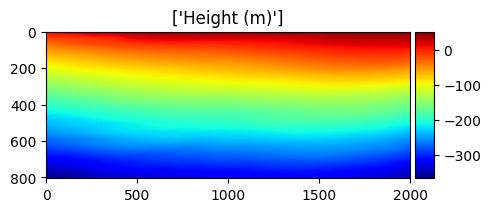

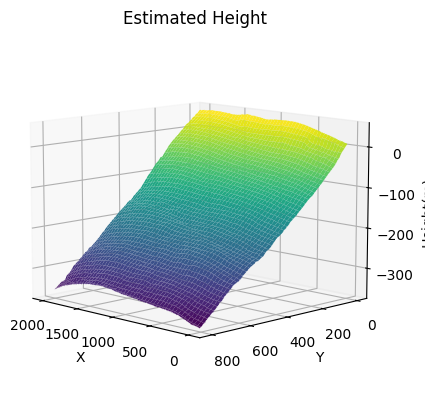

In [33]:
phi = unwrap_phase(np.array(df_theta[1]))

# while np.min(phi) < 0:
#     phi += 2 * np.pi
    
results = np.zeros((num_rows, num_cols))

results = -1 * phi / np.array(df_k[1])

plot(results, titles=["Height (m)"])
draw3D(results)


发现解缠效果优秀，但是最后高程范围来到了负数，对此整体迭代添加周期，直至下限为150

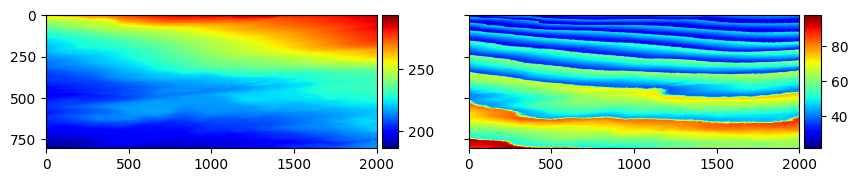

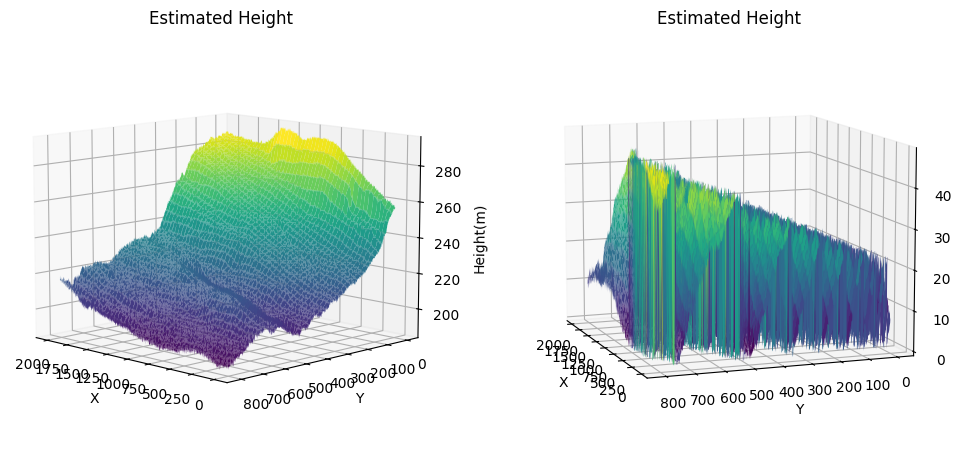

In [34]:
while np.min(results) < 150:
    results -= (2 * np.pi / df_k[1])
    
plot(results, raw_pic(1))

# draw3D(results)
H = results
N, M = H.shape
x = np.linspace(1, M, M)
y = np.linspace(1, N, N)
x, y = np.meshgrid(x, y)
fig = plt.figure(figsize=(12, 6))  # Set the figure size to be wide enough for two subplots
ax1 = fig.add_subplot(121, projection='3d')  # Change this to 121 for a 1x2 grid (first subplot)
ax1.plot_surface(x, y, H, cmap='viridis')
ax1.set_title('Estimated Height')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Height(m)')
ax1.view_init(elev=10, azim=135)

# Second plot
H = -1 * (np.array(df_theta[1])) / np.array(df_k[1])
N, M = H.shape
x = np.linspace(1, M, M)
y = np.linspace(1, N, N)
x, y = np.meshgrid(x, y)
ax2 = fig.add_subplot(122, projection='3d')  # Change this to 122 for a 1x2 grid (second subplot)
ax2.plot_surface(x, y, H, cmap='viridis')
ax2.set_title('Estimated Height')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Height(m)')
ax2.view_init(elev=10, azim=160)

plt.show()

发现结果正好在题目给定范围内，对此做验证（2～5)组：

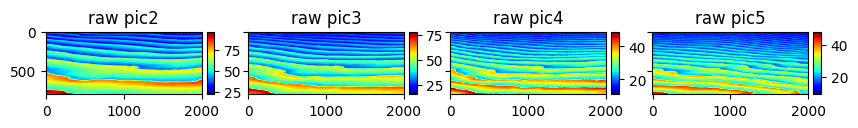

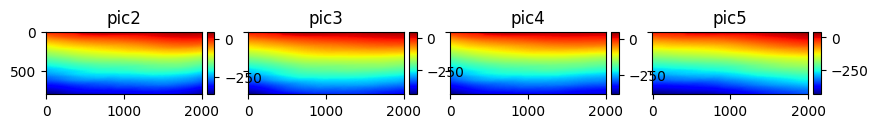

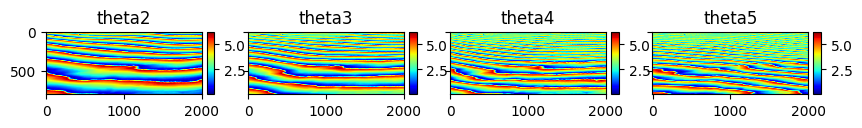

In [37]:
results = np.zeros((4, num_rows, num_cols))
for o in range(1, 5):
    phi = unwrap_phase(np.array(df_theta[o]))
                
    results[o-1] = -1 * phi / np.array(df_k[o])
  
plot(raw_pic(1), raw_pic(2), raw_pic(3), raw_pic(4), titles=[f"raw pic{i+1}" for i in range(1, 5)])      
plot(results[0], results[1], results[2], results[3], titles=[f"pic{i+1}" for i in range(1, 5)])
plot(df_theta[1], df_theta[2], df_theta[3], df_theta[4], titles=[f"theta{i+1}" for i in range(1, 5)])


这里使用numpy自带的解缠方法对两个轴向上进行解缠分别查看效果（以第五组为例）

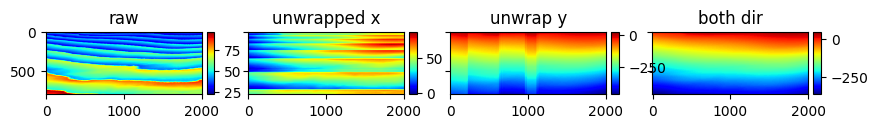

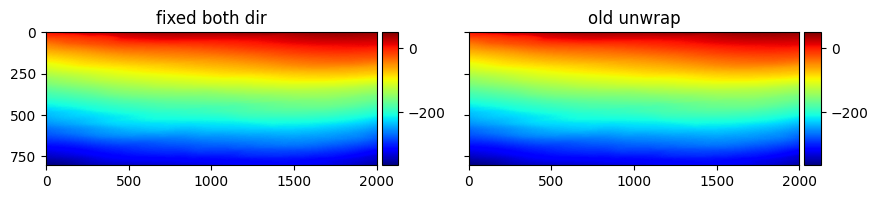

In [38]:
theta = np.array(df_theta[1]) 
k4 = np.array(df_k[1])

# 使用numpy的unwrap函数对theta进行处理
# 默认情况下，unwrap会沿着最后一个轴处理，对于二维矩阵来说，就是沿着每一行处理
# 如果你想沿着其他轴处理，可以使用axis参数
phix = np.unwrap(theta, axis=1)
phiy = np.unwrap(theta, axis=0)
phi = (np.unwrap(phix, axis=0))

results = np.zeros((3 ,num_rows, num_cols))


for i in range(3):
    if not i:
        results[i] = -1 * phix / k4
        continue
    elif i % 2:
        results[i] = -1 * phiy / k4
    elif not i % 2:
        results[i] = -1 * phi / k4

plot(raw_pic(1), results[0], results[1], results[2], titles=["raw" , "unwrapped x" ,"unwrap y", "both dir"])

        
results[0] = -1 / k4 * unwrap_phase(theta)


plot(results[2], results[0]  , titles=[ "fixed both dir", "old unwrap"])


可见两种方法得出的效果非常相近

遍历所有数据，查看每组数据高程图还原的步长和结果,还原是对相位调整$2 n \pi$

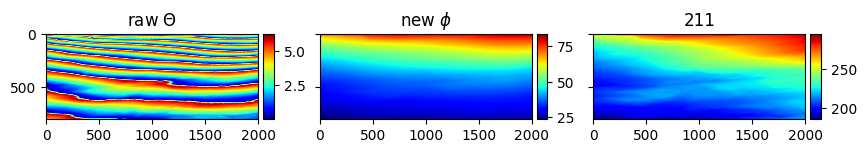

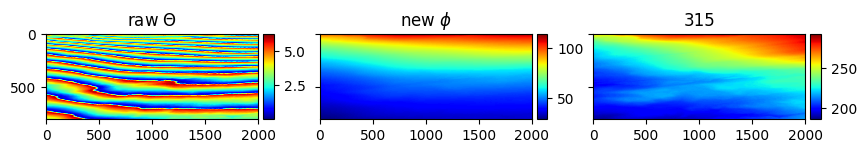

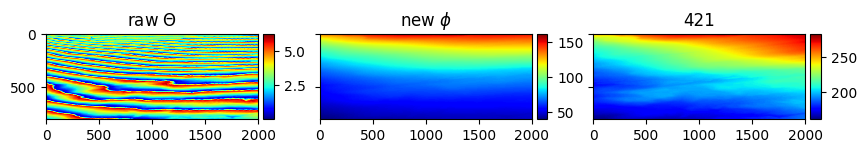

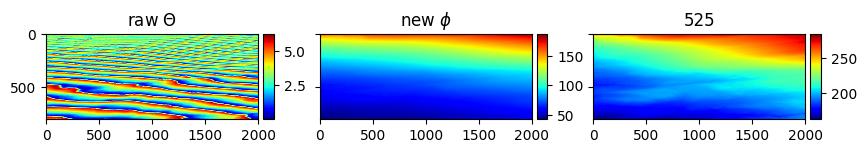

In [39]:
h = np.zeros((num_rows, num_cols))

for i in range(1,5):
    step = (i+1) * 100
    phi = unwrap_phase(np.array(df_theta[i]))
    h = -1 * phi / df_k[i]
    while np.min(h) < 150 or np.max(h) > 300:
        step += 1
        phi += 2 * np.pi
        h = -1 * phi / df_k[i]
        if np.min(h) >= 150 and np.max(h) <= 300:
            plot(df_theta[i], phi, h, titles=["raw $\Theta$", "new $\phi$", f"{step}"])
            



发现随着原始相位图纠缠条纹变密集，还原高程图的步骤逐渐变长，而最后还原出的色度图相差无几，验证了题目测量的是同一地区的题干

自主模拟生产相位图 与 对应的纠缠图

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def simulate(size, m_1, m_2, C, A, mu_x, mu_y, sigma_x, sigma_y):
  """
  creates an arbitrary phase map by mixing gaussian blobs and adding ramps
  """
  x = np.arange(0, size[0], 1)
  y = np.arange(0, size[0], 1)
  xx, yy = np.meshgrid(x, y, sparse=True)
  I = np.zeros(size)
  ## mix randomly shaped and placed gaussian blobs
  
  for i in range(len(sigma_x)):
      a = (xx-mu_x[i])**2/(2*sigma_x[i]**2) + (yy-mu_y[i])**2/(2*sigma_y[i]**2)
      I += A[i]*np.exp(-a)
  ## add ramp phase with random gradients and shifts
  I = m_1*xx + m_2*yy + C + 0.1*I
  return I

def wrap(phi):
  """
  wraps the true phase signal within [-pi, pi]
  """
  return np.angle(np.exp(1j*phi))

def rescale(im, range):
  """
  mini-max rescales the input image
  """
  im_std = (im - im.min()) / (im.max() - im.min())
  im_scaled = im_std * (range[1] - range[0]) + range[0]
  return im_scaled

def create_random_image(size):
  """
  creates an randomly simulated true phase map
  """ 
  array_len = np.random.randint(2, 5)
  m = np.random.uniform(0, 0.5, [2])
  C = np.random.randint(1, 10)
  A = np.random.randint(50, 1000, array_len)
  mu_x = np.random.randint(round(size[0] / 4), round(size[1] * 3 / 4), array_len)
  mu_y = np.random.randint(round(size[0] / 4), round(size[1] * 3 / 4), array_len)
  sigma_x = np.random.randint(10, 45, array_len)
  sigma_y = np.random.randint(10, 45, array_len)
  I = simulate(size, m[0], m[1], C, A, mu_x, mu_y, sigma_x, sigma_y)
  return I



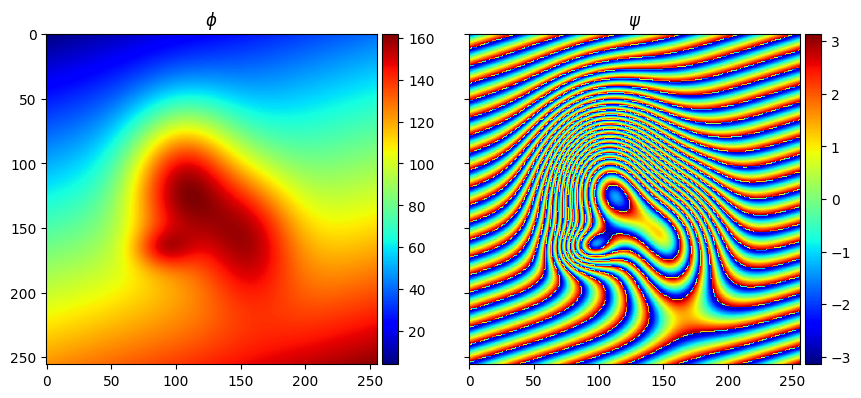

In [13]:
## example
size = (256, 256)

I = create_random_image(size)
I_wrap = wrap(I)
plot(I, I_wrap, titles=["$\phi$", "$\psi$"])

用相位展开方法解缠

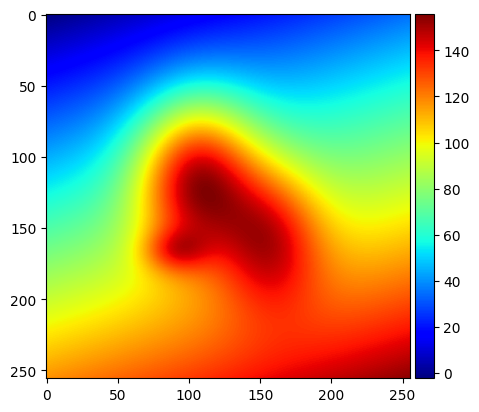

In [14]:
phi = unwrap_phase(I_wrap)

plot(phi)

以上结果发现对随机生成的相位图拟合效果不错能大体上解缠，但是依旧有一些区域效果不太好，故打算引入神经网络

以下是神经网络方法，训练过程参考tutorial

用自主模拟的相位图来训练一个模型，此处参考[一种联合性的机器学习相位解缠方法](https://ieeexplore.ieee.org/document/9414748)，使用它们的预训练模型，微调后接入我们的模型

In [15]:
import numpy as np
import h5py
import os
import matplotlib as mpl
mpl.style.use('default')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from keras.layers import Activation, BatchNormalization, Conv2D, UpSampling2D, Conv2DTranspose, concatenate
from keras.layers import MaxPooling2D, Dropout, Input, AveragePooling2D, Reshape, Permute, UpSampling2D
from keras.layers import SimpleRNN, Bidirectional, LSTM
from keras.layers import Lambda
from keras.losses import sparse_categorical_crossentropy
import tensorflow as tf
from keras.optimizers import *
import keras.backend as K
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
K.set_image_data_format('channels_last')

引用论文模型原型用于导入模型（修改了尺寸）

In [16]:
def get_joint_conv_sqd_lstm_net():
    """
    Defines the joint convoltional and spatial quad-directional LSTM network
    """
    ## input to the network
    input = Input((256, 256, 1))

    ## encoder network
    c1 = Conv2D(filters=16, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(input)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = AveragePooling2D()(c1)

    c2 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = AveragePooling2D()(c2)

    c3 = Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = AveragePooling2D()(c3)

    c4 = Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    p4 = AveragePooling2D()(c4)

    # SQD-LSTM Block
    x_hor_1 = Reshape((16 * 16, 128))(p4)
    x_ver_1 = Reshape((16 * 16, 128))(Permute((2, 1, 3))(p4))

    h_hor_1 = Bidirectional(LSTM(units=32, activation='tanh', return_sequences=True, go_backwards=False))(x_hor_1)
    h_ver_1 = Bidirectional(LSTM(units=32, activation='tanh', return_sequences=True, go_backwards=False))(x_ver_1)

    H_hor_1 = Reshape((16, 16, 64))(h_hor_1)
    H_ver_1 = Permute((2, 1, 3))(Reshape((16, 16, 64))(h_ver_1))

    c_hor_1 = Conv2D(filters=64, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_hor_1)
    c_ver_1 = Conv2D(filters=64, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_ver_1)

    H = concatenate([c_hor_1, c_ver_1])

    # decoder Network
    u5 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(H)
    u5 = concatenate([u5, c4])
    c5 = Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    u6 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c3])
    c6 = Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)

    u7 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)

    u8 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    ## output layer
    output = Conv2D(filters=1, kernel_size=(1, 1), padding='same', name='out1')(c8)
    output = Activation('linear')(output)

    model = Model(inputs=[input], outputs=[output])
    return model

加载模型

In [17]:
Model = lambda df_theta: [unwrap_phase(np.array(df_theta[i])) for i in range(5)]
Model = get_joint_conv_sqd_lstm_net()
model_path = './model/LSTM_model.h5'
Model.load_weights(model_path)

TypeError: __init__() missing 1 required positional argument: 'pool_size'

由于一开始加载了df_theta直接使用，接下来使用模型输出解缠值

In [20]:
X_test = np.array(df_theta)
Y_pred = np.zeros_like(X_test)

Y_pred = Model(X_test)

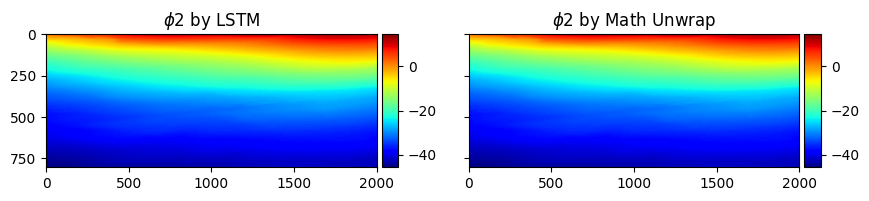

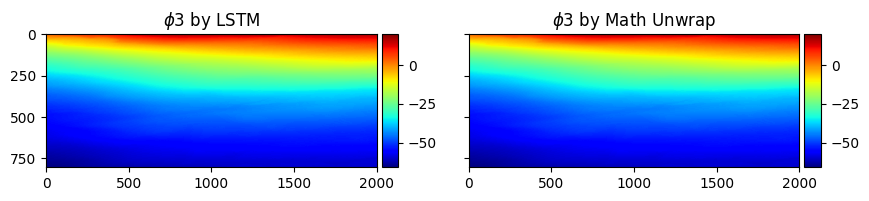

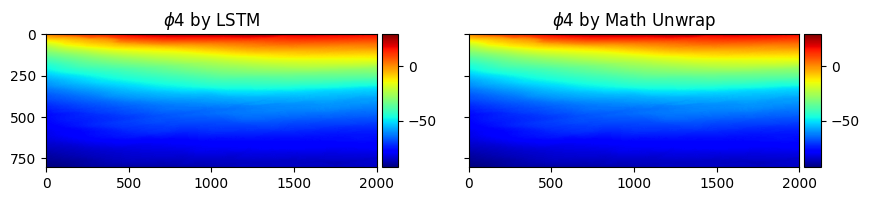

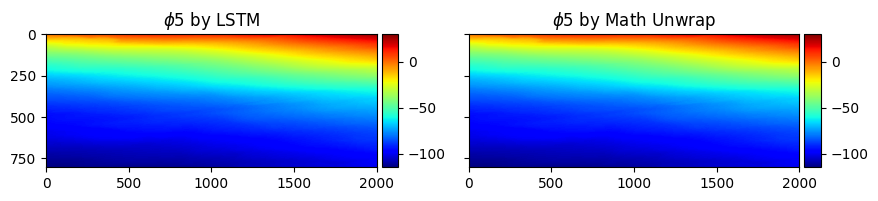

In [40]:
# 输出图像
for i in range(1,5):
    plot(Y_pred[i], unwrap_phase(np.array(df_theta[i])), titles=[f"$\phi${i+1} by LSTM", f"$\phi${i+1} by Math Unwrap"])

肉眼并不能看出这两种方法明显的区别，但是考虑到该机器学习论文训练集足够大，且在其测试集上表现非常优良，而数学方法在前面自主生成相位纠缠的图像上表现欠佳（有图像证据和论文证据），故后续全部使用LSTM方法计算$\phi$

对于第一题 需要引入一种评估方案评估$\phi$，考虑到干涉是物理光学性质，由此可以知道，当干涉条纹间隔越短，采样率更高，但随之带来的误差也会提高（假设）。
故数据5采样率最高，数据1连续性最好。我们基于先前的unwrap 函数，定义一个三维方向上的unwrap函数（在二维方向上依旧使用LSTM），假设将数据中的某n组包装到一起，就会得到一个n x 805 x 2001的矩阵，而且对每层n是极大消除误差的。

In [22]:
def unwrap_3D_phase(theta):
    # 初始化 phi 矩阵
    phi = np.zeros_like(theta)
    phi[0, 0, 0] = theta[0, 0, 0]
    
    
    # 展开每一个平面的其余矩阵
    
    for k in range(0, theta.shape[2]):
        # 展开第一个平面的行
        for i in range(1, theta.shape[0]):
            delta = theta[i, 0, k] - theta[i-1, 0, k]
            delta_wrapped = np.mod(delta + np.pi, 2 * np.pi) - np.pi
            phi[i, 0, k] = phi[i-1, 0, k] + delta_wrapped
        
        # 展开第一个平面的列
        for j in range(1, theta.shape[1]):
            delta = theta[0, j, k] - theta[0, j-1, k]
            delta_wrapped = np.mod(delta + np.pi, 2 * np.pi) - np.pi
            phi[0, j, k] = phi[0, j-1, k] + delta_wrapped
            
        for i in range(1, theta.shape[0]):
            for j in range(1, theta.shape[1]):
                delta_row = theta[i, j, k] - theta[i-1, j, k]
                delta_col = theta[i, j, k] - theta[i, j-1, k]
                delta_row_wrapped = np.mod(delta_row + np.pi, 2 * np.pi) - np.pi
                delta_col_wrapped = np.mod(delta_col + np.pi, 2 * np.pi) - np.pi
                phi[i, j, k] = phi[i-1, j, k] + delta_row_wrapped
                phi[i, j, k] = phi[i, j-1, k] + delta_col_wrapped
               
    #展开深度方向
    depth = lambda theta, phi: np.array([[[phi[i-1, j, k] + (np.mod(theta[i, j, k] - theta[i-1, j, k] + np.pi, 2 * np.pi) - np.pi) if i > 0 else phi[i, j, k],
                                         phi[i, j-1, k] + (np.mod(theta[i, j, k] - theta[i, j-1, k] + np.pi, 2 * np.pi) - np.pi) if j > 0 else phi[i, j, k],
                                         phi[i, j, k-1] + (np.mod(theta[i, j, k] - theta[i, j, k-1] + np.pi, 2 * np.pi) - np.pi) if k > 0 else phi[i, j, k]]
                                        for j in range(theta.shape[1])]])
 
    
    return phi

分别用数学方法和神经网络方法计算每组数据的高程值
数学方法在前面已经做过，以下是神经网络方法求出的高程值，我们主要考虑迭代步数s

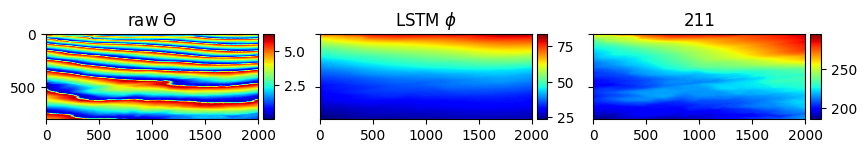

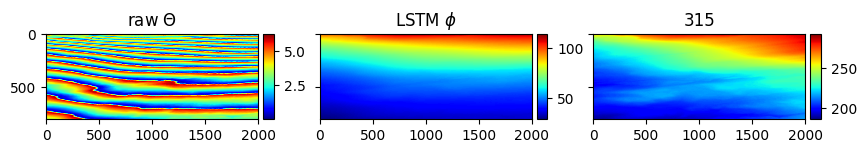

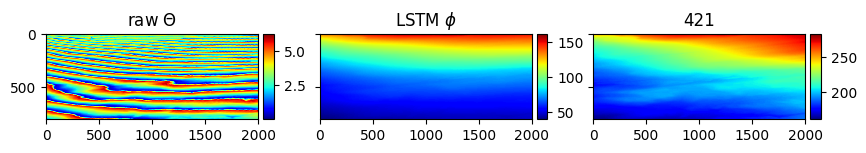

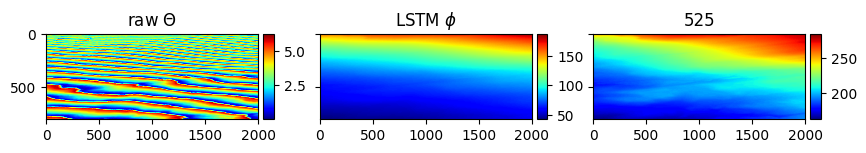

In [41]:
h = np.zeros((num_rows, num_cols))
s = []
s.append(0)
for i in range(1,5):
    step = (i+1) * 100
    phi = unwrap_phase(Y_pred[i])
    h = -1 * phi / df_k[i]
    while np.min(h) < 150 or np.max(h) > 300:
        step += 1
        phi += 2 * np.pi
        h = -1 * phi / df_k[i]
        if np.min(h) >= 150 and np.max(h) <= 300:
            plot(df_theta[i], phi, h, titles=["raw $\Theta$", "LSTM $\phi$", f"{step}"])
            s.append(step%100)
            


上图也可以看出随着原始样本复杂性变高得到的phi的极差也变大了，说明在同等大小信息容器下，第五组数据相较于第一组，信息密度更高，即采样率越大验证了我们评估方案合理性。

我们得到的s是迭代次数，反映了采样率，这将作为我们混合量化的权重考虑参数，次数越多，权重越大.
对给定极大消除误差过的生成的n x 805 x 2001的矩阵，我们要将其最后分权转为805 x 2001的矩阵，就需要乘上一个权重矩阵。

我们先选取第一组和第五组尝试计算

2 5

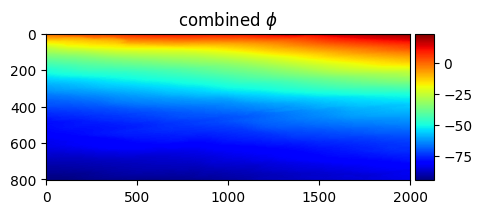

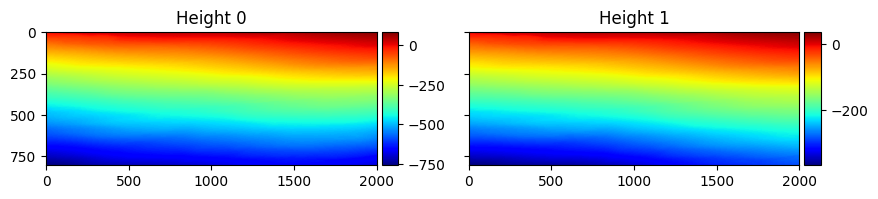

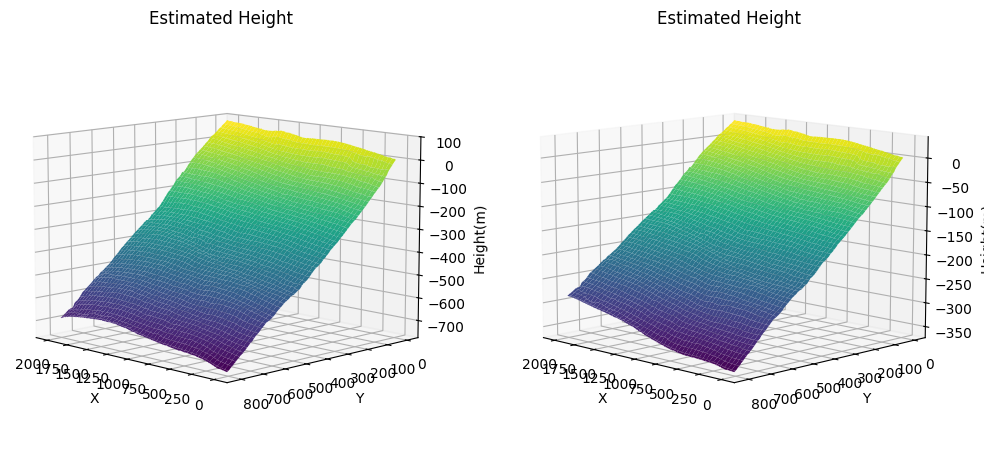

In [42]:
combine_2_5 = np.zeros((num_rows, num_cols, 2))

for i in range(num_rows):
    for j in range(num_cols):
        combine_2_5[i][j][0] = Y_pred[1][i][j]
        combine_2_5[i][j][1] = Y_pred[4][i][j]

weight = np.zeros((2,1))
weight1 = s[1] / (s[1] + s[4])
weight2 = s[4] / (s[1] + s[4])
weight[0][0] = weight1
weight[1][0] = weight2

combine_2_5 = unwrap_3D_phase(combine_2_5)
combine = np.zeros((num_rows, num_cols))

tmp = np.zeros((num_rows, num_cols))

combine = combine_2_5 @ weight

# for i in range(num_rows):
#     for j in range(num_cols):
#         tmp[i][j] = combine_1_5[i][j][0] * weight1 + combine_1_5[i][j][1] * weight2
        
combine = combine.ravel().reshape((num_rows,num_cols))
# combine = tmp
# print(combine.shape)
# for i in range(num_rows):
#     for j in range(num_cols):
#         combine[i][j] = combine_1_5[0][i][j] * s[0] / (s[0] + s[4]) + combine_1_5[1][i][j] * s[4] / (s[0] + s[4])
        
plot(combine, titles="combined $\phi$")

plot((-1 * combine / df_k[1]), (-1 * combine / df_k[4]), titles=["Height 0", "Height 1"])

H = -1 * combine / df_k[1]

N, M = H.shape
x = np.linspace(1, M, M)
y = np.linspace(1, N, N)
x, y = np.meshgrid(x, y)
fig = plt.figure(figsize=(12, 6))  # Set the figure size to be wide enough for two subplots
ax1 = fig.add_subplot(121, projection='3d')  # Change this to 121 for a 1x2 grid (first subplot)
ax1.plot_surface(x, y, H, cmap='viridis')
ax1.set_title('Estimated Height')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Height(m)')
ax1.view_init(elev=10, azim=135)

# Second plot
H = -1 * combine / df_k[4]

N, M = H.shape
x = np.linspace(1, M, M)
y = np.linspace(1, N, N)
x, y = np.meshgrid(x, y)
ax2 = fig.add_subplot(122, projection='3d')  # Change this to 122 for a 1x2 grid (second subplot)
ax2.plot_surface(x, y, H, cmap='viridis')
ax2.set_title('Estimated Height')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Height(m)')
ax2.view_init(elev=10, azim=135)

plt.show()


用先前的方法将高程移至区间内

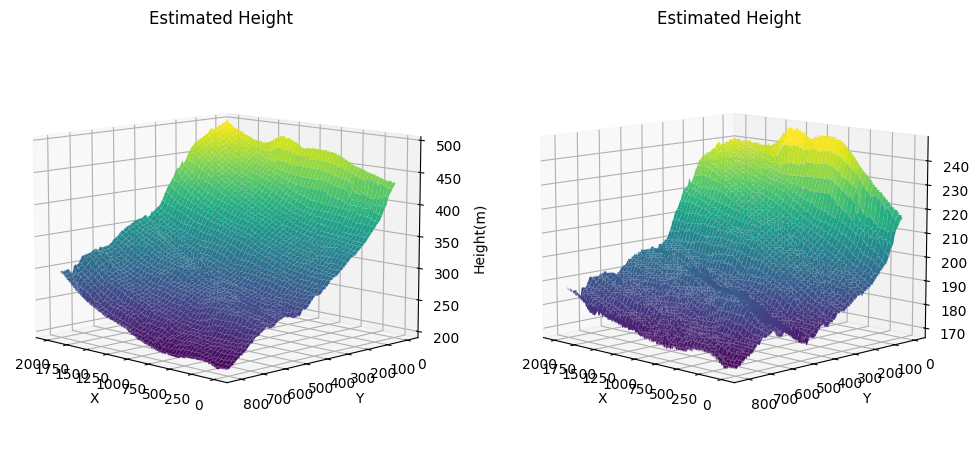

In [43]:
phi = combine

H = -1 * phi / df_k[1]
while np.min(H) < 150 :
    phi += 2 * np.pi
    H = -1 * phi / df_k[1]


N, M = H.shape
x = np.linspace(1, M, M)
y = np.linspace(1, N, N)
x, y = np.meshgrid(x, y)
fig = plt.figure(figsize=(12, 6))  # Set the figure size to be wide enough for two subplots
ax1 = fig.add_subplot(121, projection='3d')  # Change this to 121 for a 1x2 grid (first subplot)
ax1.plot_surface(x, y, H, cmap='viridis')
ax1.set_title('Estimated Height')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Height(m)')
ax1.view_init(elev=10, azim=135)

# plt.show()
# Second plot
phi = combine
H = -1 * phi / df_k[4]
while np.min(H) < 150 :
    phi += 2 * np.pi
    H = -1 * phi / df_k[4]
N, M = H.shape
x = np.linspace(1, M, M)
y = np.linspace(1, N, N)
x, y = np.meshgrid(x, y)
ax2 = fig.add_subplot(122, projection='3d')  # Change this to 122 for a 1x2 grid (second subplot)
ax2.plot_surface(x, y, H, cmap='viridis')
ax2.set_title('Estimated Height')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Height(m)')
ax2.view_init(elev=10, azim=135)

plt.show()

验证第五组数据上界

In [26]:
print(np.max(H))

248.30459484076502


综上，由于第五组数据采样率最高，故选择第五组数据的k来高程恢复，由此得出四个顶点的高程值

(805, 2001)


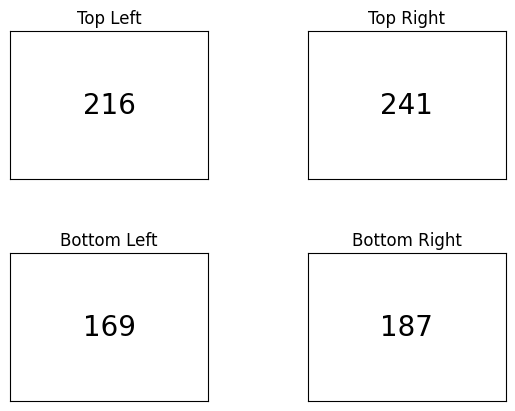

In [44]:
print(H.shape)

final = np.array(H)
# 获取四个顶点的值
top_left = round(final[0, 0])
top_right = round(final[0, num_cols-1])
bottom_left = round(final[num_rows-1, 0])
bottom_right = round(final[num_rows-1, num_cols-1])

# 创建一个2x2的图
fig, axs = plt.subplots(2, 2)

# 设置四个顶点的值
axs[0, 0].text(0.5, 0.5, str(top_left), ha='center', va='center', size=20)
axs[0, 0].set_title('Top Left')
axs[0, 1].text(0.5, 0.5, str(top_right), ha='center', va='center', size=20)
axs[0, 1].set_title('Top Right')
axs[1, 0].text(0.5, 0.5, str(bottom_left), ha='center', va='center', size=20)
axs[1, 0].set_title('Bottom Left')
axs[1, 1].text(0.5, 0.5, str(bottom_right), ha='center', va='center', size=20)
axs[1, 1].set_title('Bottom Right')

# 隐藏坐标轴
for ax in axs.flat:
    ax.set(xticks=[], yticks=[])

# 调整子图间距
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.show()


n越大采样率越高，对于第一题，我们既要保证采样率，又要保证误差最小，以下代码，反映五组数据的方差

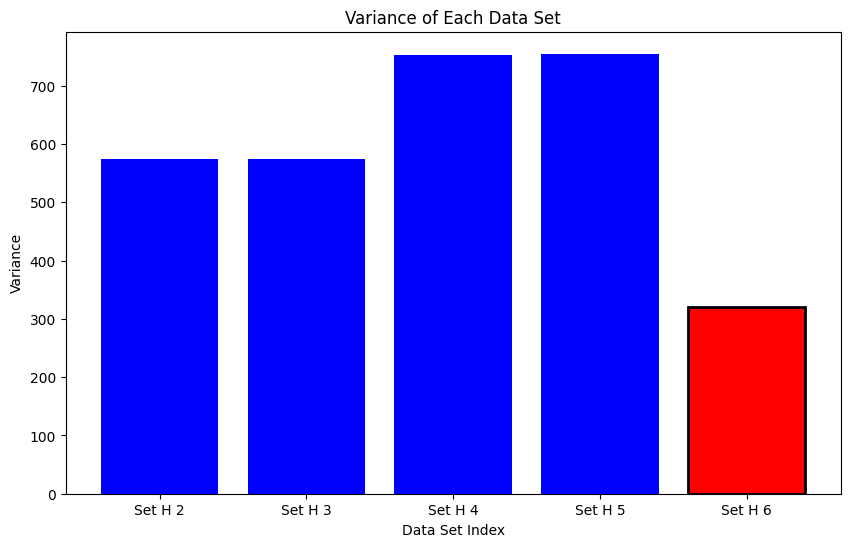

In [45]:
vars = []
vars_for_dis = []
hs = []

h = np.zeros((num_rows, num_cols))
for i in range(1,5):
    phi = unwrap_phase(Y_pred[i])
    h = -1 * phi / df_k[i]
    while np.min(h) < 150 or np.max(h) > 300:
        phi += 2 * np.pi
        h = -1 * phi / df_k[i]
        if np.min(h) >= 150 and np.max(h) <= 300:
            hs.append(h)
            vars.append(np.array(h).flatten())
    
            
for i in range(1,5):
    vars_for_dis.append(np.var(vars[i-1], ddof=1))

vars_for_dis.append(np.var(final.flatten(), ddof=1))
hs.append(final)

# print(vars_for_dis[i] for i in range(6))


# 创建直方图
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(vars_for_dis)), vars_for_dis, color='b')

# 高亮最后一个数据
bars[-1].set_color('r')
bars[-1].set_edgecolor('black')
bars[-1].set_linewidth(2)

# 添加标签和标题
plt.xlabel('Data Set Index')
plt.ylabel('Variance')
plt.title('Variance of Each Data Set')
plt.xticks(range(len(vars_for_dis)), [f'Set H {i+2}' for i in range(len(vars_for_dis))])

# 显示图表
plt.show()


由以上直方图可以看出我们的模型相较于原始模型有非常明显的方差降低，代表误差与精度的提升

接下来使用梯度平均值查看我们模型的精度

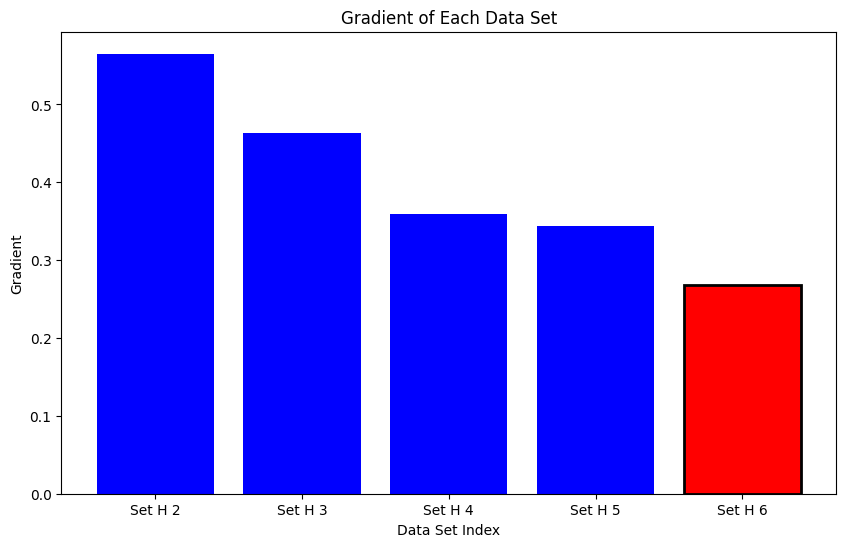

In [46]:
hs_for_dis = []

for i in range(1, 6):   
    gradient_x, gradient_y = np.gradient(np.array(hs[i-1]))
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    # 计算梯度的平均值作为光滑程度的指标
    smoothness_gradient = np.mean(gradient_magnitude)
    hs_for_dis.append(smoothness_gradient)
   
# 创建直方图
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(hs_for_dis)), hs_for_dis, color='b')

# 高亮最后一个数据
bars[-1].set_color('r')
bars[-1].set_edgecolor('black')
bars[-1].set_linewidth(2)

# 添加标签和标题
plt.xlabel('Data Set Index')
plt.ylabel('Gradient')
plt.title('Gradient of Each Data Set')
plt.xticks(range(len(hs_for_dis)), [f'Set H {i+2}' for i in range(len(hs_for_dis))])

# 显示图表
plt.show() 


由以上直方图可以看出我们的模型相较于原始模型有一定程度的梯度降低，图像光滑程度也有所提高

接下来遍历$\underset{i=2}{\overset{4}{C^i_4}}$

In [48]:
binom = []
hs = []


for i in range(1, 5):
    for j in range(i+1, 5):  
        binom_2_4 = np.zeros((num_rows, num_cols, 2))
        for x in range(num_rows):
            for y in range(num_cols):
                binom_2_4[x][y][0] = Y_pred[i][x][y]
                binom_2_4[x][y][1] = Y_pred[j][x][y]
        weight = np.zeros((2,1))
        weight1 = s[i] / (s[i] + s[j])
        weight2 = s[j] / (s[i] + s[j])
        weight[0][0] = weight1
        weight[1][0] = weight2
        binom_2_4 = unwrap_3D_phase(binom_2_4)
        binom24 = np.zeros((num_rows, num_cols))
        binom24 = binom_2_4 @ weight
        binom24 = binom24.ravel().reshape((num_rows, num_cols))
        while np.min(-1 * binom24 / df_k[j]) < 150:
            binom24 += 2 * np.pi
        binom.append(-1 * binom24 / df_k[j])
 

binom.append(final)

            

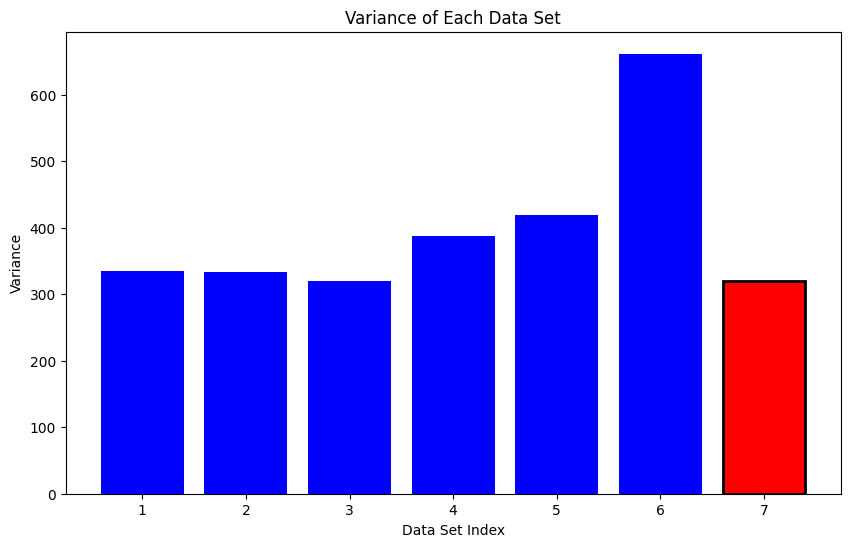

In [49]:

vars = []
vars_for_dis = []
hs = []

for i in range(len(binom)):
    vars.append(np.array(binom[i]).flatten() )
 
for i in range(len(vars)):
   vars_for_dis.append(np.var(vars[i], ddof=1))


# 创建直方图
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(vars_for_dis)), vars_for_dis, color='b')

# 高亮最后一个数据
bars[-1].set_color('r')
bars[-1].set_edgecolor('black')
bars[-1].set_linewidth(2)

# 添加标签和标题
plt.xlabel('Data Set Index')
plt.ylabel('Variance')
plt.title('Variance of Each Data Set')
plt.xticks(range(len(vars_for_dis)), [f'{i+1}' for i in range(len(vars_for_dis))])

# 显示图表
plt.show()



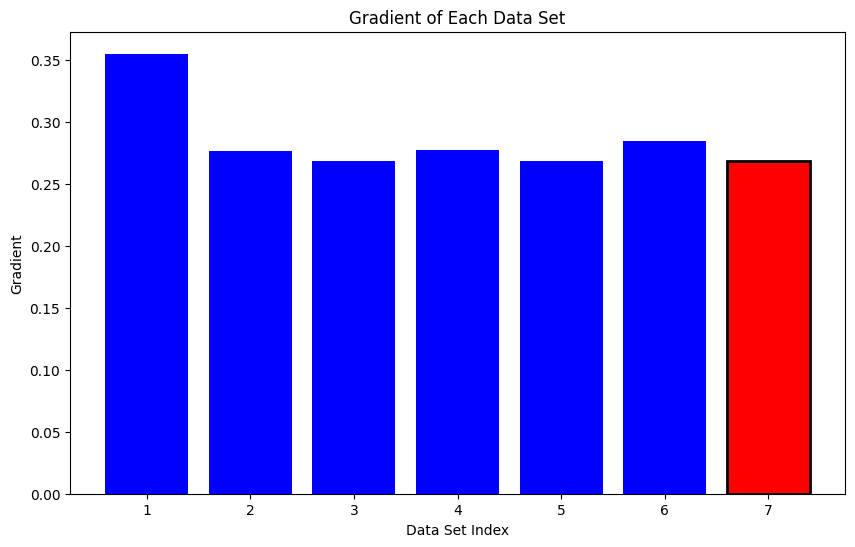

In [51]:
hs_for_dis = []

for i in range(len(binom)):   
    gradient_x, gradient_y = np.gradient(np.array(binom[i]))
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    # 计算梯度的平均值作为光滑程度的指标
    smoothness_gradient = np.mean(gradient_magnitude)
    hs_for_dis.append(smoothness_gradient)
   
# 创建直方图
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(hs_for_dis)), hs_for_dis, color='b')

# 高亮最后一个数据
bars[-1].set_color('r')
bars[-1].set_edgecolor('black')
bars[-1].set_linewidth(2)

# 添加标签和标题
plt.xlabel('Data Set Index')
plt.ylabel('Gradient')
plt.title('Gradient of Each Data Set')
plt.xticks(range(len(hs_for_dis)), [f'{i+1}' for i in range(len(hs_for_dis))])

# 显示图表
plt.show() 


In [ ]:
# TODO

In [ ]:
#TODO

发现应该选 TODO

In [ ]:
phi1 = unwrap_phase(np.array(df_theta[0]))
phi2 = unwrap_phase(np.array(df_theta[1]))

h1 = np.zeros((num_rows, num_cols))
h2 = np.zeros((num_rows, num_cols)) 

# step = 0
# 
# weight1 = n2 / (n1+n2)
# weight2 = n1 / (n1+n2)
# 
# phi = phi1 * weight1 + phi2 * weight2
# 
# h1 = -1 * phi / df_k[0]
# h2 = -1 * phi / df_k[1]
# 
# plot(h1, h2, titles=[f"h1,{np.min(h1)},{np.max(h1)}", f"h2,{np.min(h2)},{np.max(h2)}"])
#     

减少误差，综合多组数据验证以上值


In [ ]:
phi_1d = np.zeros((5, num_rows * num_cols))
for i in range(5):
    phi_1d[i] = unwrap_phase(Y_pred[i]).flatten()
    
sq = np.zeros((5, 5))
phi_1d = np.array(phi_1d)
sq = phi_1d @ phi_1d.T

sq_normalized = sq / np.linalg.norm(sq)
# Plot the normalized matrix using Matplotlib
plt.imshow(sq_normalized, cmap='viridis')
plt.colorbar()
plt.title('Normalized Matrix sq')
plt.show()
print(sq)
